In [14]:
import pandas as pd
import xgboost
from xgboost import XGBClassifier
import xgboost
import pickle
import numpy as np
from time import time

In [2]:
train_data = pd.read_parquet("sets/train_data.parquet")

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    train_data.drop(columns=["y", "transaction_id"]), train_data["y"], test_size=0.2, random_state=0
)

In [4]:
cat_features = ["category", "alley_id", "day_of_week", "time_of_day"]
num_features = [c for c in X_train.columns if c not in cat_features]

In [5]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                [
                    # ("imputer", SimpleImputer(strategy='median')),
                    ("min_max_scaler", MinMaxScaler())
                ]
            ),
            num_features,
        ),
        (
            "cat",
            Pipeline(
                [
                    # ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
                ]
            ),
            cat_features,
        ),
    ],
    remainder="passthrough",
)

In [6]:
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

feature_names = preprocessor.get_feature_names_out()

In [7]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit

param_grid = {
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "n_estimators": [300, 500, 700],
}

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1],
)

search = GridSearchCV(
    xgb, param_grid, cv=ShuffleSplit(n_splits=1, test_size=0.20, random_state=0), scoring="f1", verbose=3
)

start = time()
search.fit(X_train_processed, y_train)
end = time()

print("Total time: ", end - start)

print("Best hyperparameters:", search.best_params_)

print("Best score: ", search.best_score_)

classifier = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", search.best_estimator_),
    ]
)

with open("xgboost.pkl", "wb") as f:
    pickle.dump(classifier, f)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV 1/1] END learning_rate=0.05, max_depth=4, n_estimators=300;, score=0.362 total time= 2.1min
[CV 1/1] END learning_rate=0.05, max_depth=4, n_estimators=500;, score=0.362 total time= 2.9min
[CV 1/1] END learning_rate=0.05, max_depth=4, n_estimators=700;, score=0.364 total time= 5.0min
[CV 1/1] END learning_rate=0.05, max_depth=6, n_estimators=300;, score=0.364 total time= 2.8min
[CV 1/1] END learning_rate=0.05, max_depth=6, n_estimators=500;, score=0.366 total time= 4.1min
[CV 1/1] END learning_rate=0.05, max_depth=6, n_estimators=700;, score=0.371 total time= 5.8min
[CV 1/1] END learning_rate=0.1, max_depth=4, n_estimators=300;, score=0.362 total time=  1.6min
[CV 1/1] END learning_rate=0.1, max_depth=4, n_estimators=500;, score=0.364 total time=  2.8min
[CV 1/1] END learning_rate=0.1, max_depth=4, n_estimators=700;, score=0.366 total time=  3.7min
[CV 1/1] END learning_rate=0.1, max_depth=6, n_estimators=300;, score=0.367

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

xgb = search.best_estimator_
y_pred = xgb.predict_proba(X_val_processed)[:, 1]
auroc = roc_auc_score(y_val, y_pred)

print("AUROC", auroc)
print(classification_report(y_val, y_pred > 0.5))

AUROC 0.8144532118896244
              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85    1015530
         1.0       0.25      0.74      0.37     111000

    accuracy                           0.77    1126530
   macro avg       0.60      0.74      0.61    1126530
weighted avg       0.89      0.76      0.80    1126530



<BarContainer object of 10 artists>

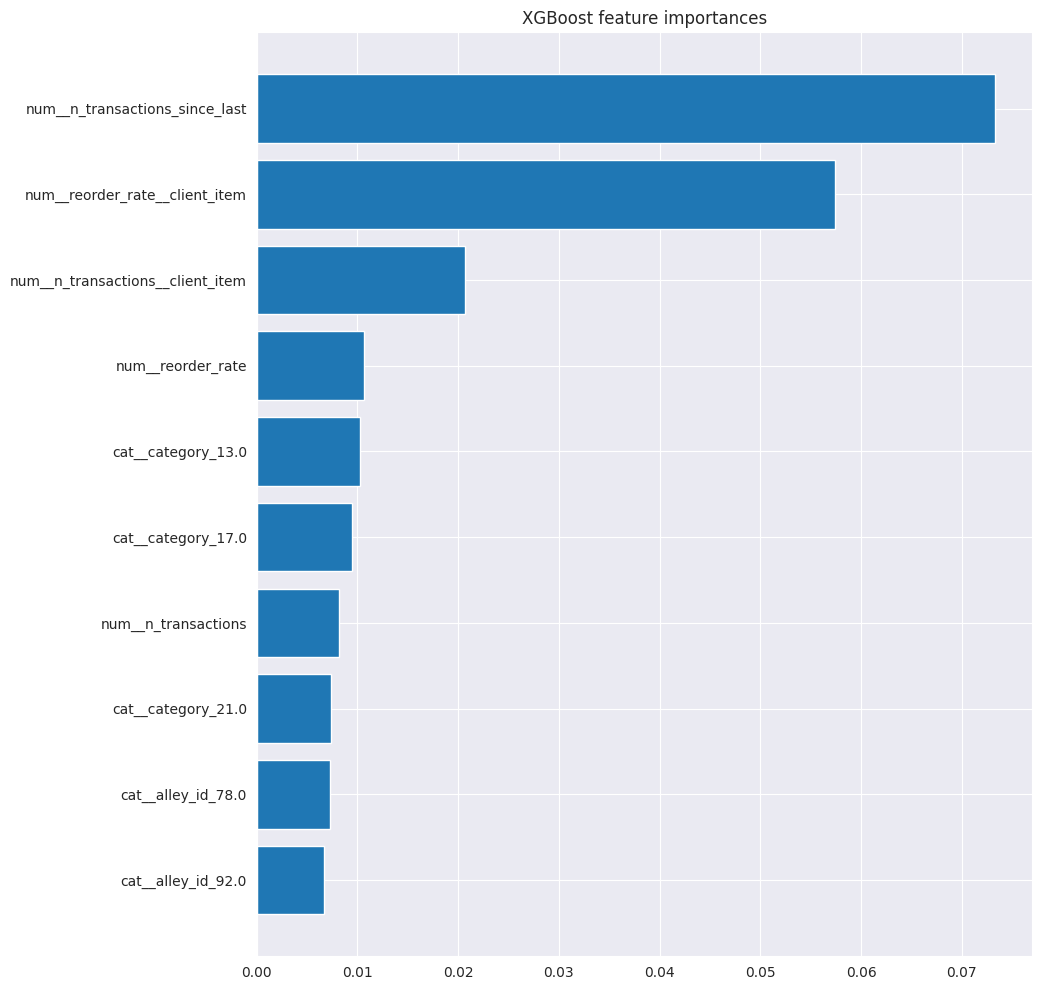

In [26]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, figsize=(10, 12))
ax.set_title("XGBoost feature importances")

sorted_coefficients = sorted(
    zip(feature_names, xgb.feature_importances_),
    key=lambda x: x[1],
)

ax.barh(*zip(*sorted_coefficients[-10:]))

In [27]:
classifier = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", xgb),
    ]
)

with open("xgboost.pkl", "wb") as f:
    pickle.dump(classifier, f)